In [1]:
from mcmc import mcmc_run, slab_energy

from ase.calculators.eam import EAM
from ase.calculators.lammpsrun import LAMMPS
from ase.io import read

from catkit.gen.adsorption import get_adsorption_sites

import os
import numpy as np

import sys
sys.path.append("/home/dux/")
from htvs.djangochem.pgmols.utils import surfaces

In [2]:
from time import perf_counter

num_runs = 300

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Au_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Au_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

# Au from standard cell
atoms = read('Au_mp-81_conventional_standard.cif')
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
slab.write('Au_110_pristine_slab.cif')

slab.calc = lammps_calc
print(f"pristine slab energy is {slab_energy(slab)}")

# calculated energy of desorbed rows (alternating rows removed)
# removed_rows = read('Au_110_desorbed_row.cif')
# removed_rows.calc = lammps_calc
# print(f"desorbed slab energy is {slab_energy(removed_rows)}")

# calculated energy of desorbed rows (2 adjacent rows removed)
# removed_2rows = read('Au_110_desorbed_2rows.cif')
# removed_2rows.calc = lammps_calc
# print(f"desorbed 2 adjacent rows slab energy is {slab_energy(removed_2rows)}")

# mcmc_slab = read('Au_200sweeps_removed.cif')
# mcmc_slab.calc = lammps_calc
# print(f"200 sweeps canonical slab energy is {slab_energy(mcmc_slab)}")

# mcmc_slab = read('Au_300sweeps_removed.cif')
# mcmc_slab.calc = lammps_calc
# print(f"300 sweeps canonical slab energy is {slab_energy(mcmc_slab)}")

/home/dux/.local/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(


pristine slab energy is -219.6481266447049


/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(


In [3]:
element = 'Au'
num_ads_atoms = 16 + 8 # for canonical runs
alpha = 0.99

start = perf_counter()
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

INFO:Running with num_runs = 300, temp = 1, pot = 0, alpha = 0.99
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


there are 64 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7fb4786510d0>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 300 runs
INFO:In sweep 1 out of 300
INFO:In sweep 2 out of 300
INFO:In sweep 3 out of 300
INFO:In sweep 4 out of 300
INFO:In sweep 5 out of 300
INFO:In sweep 6 out of 300
INFO:In sweep 7 out of 300
INFO:In sweep 8 out of 300
INFO:In sweep 9 out of 300
INFO:In sweep 10 out of 300
INFO:In sweep 11 out of 300
INFO:In sweep 12 out of 300
INFO:In sweep 13 out of 300
INFO:In sweep 14 out of 300
INFO:In sweep 15 out of 300
INFO:In sweep 16 out of 300
INFO:In sweep 17 out of 300
INFO:In sweep 18 out of 300
INFO:In sweep 19 out of 300
INFO:In sweep 20 out of 300
INFO:In sweep 21 out of 300
INFO:In sweep 22 out of 300
INFO:In sweep 23 out of 300
INFO:In sweep 24 out of 300
INFO:In sweep 25 out of 300
INFO:In sweep 26 out of 300
INFO:In sweep 27 out of 300
INFO:In sweep 28 out of 300
INFO:In sweep 29 out of 300
INFO:In sweep 30 out of 300
INFO:In sweep 31 out of 300
INFO:In sweep 32 out o

Time taken = 729.184504210949 seconds


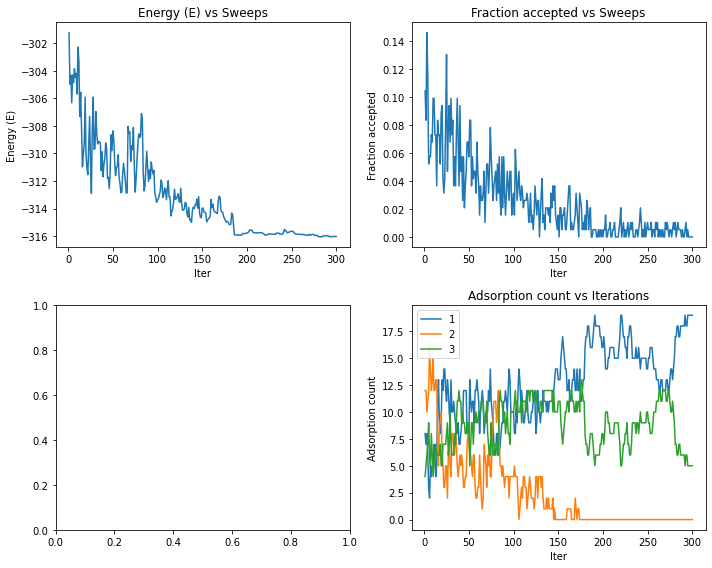

In [4]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

Try without annealing

In [9]:
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
element = 'Au'
num_ads_atoms = 16 + 8 # for canonical runs
alpha = 1

start = perf_counter()
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

INFO:Running with num_runs = 300, temp = 1, pot = 0, alpha = 1
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


there are 64 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7efd29d92880>


INFO:In pristine slab, there are a total of 192 sites
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
INFO:running for 192 iterations per run over a total of 300 runs
INFO:In sweep 1 out of 300
INFO:In sweep 2 out of 300
INFO:In sweep 3 out of 300
INFO:In sweep 4 out of 300
INFO:In sweep 5 out of 300
INFO:In sweep 6 out of 300
INFO:In sweep 7 out of 300
INFO:In sweep 8 out of 300
INFO:In sweep 9 out of 300
INFO:In sweep 10 out of 300
INFO:In sweep 11 out of 300
INFO:In sweep 12 out of 300
INFO:In sweep 13 out of 300
INFO:In sweep 14 out of 300
INFO:In sweep 15 out of 300
INFO:In sweep 16 out of 300
INFO:In sweep 17 out of 300
INFO:In sweep 18 out of 300
INFO:In sweep 19 out of 300
INFO:In sweep 20 out of 300
INFO:In sweep 21 out of 300
INFO:In sweep 22 out of 300
INFO:In sweep 23 out of 300
INFO:In sweep 24 out of 300
INFO:In s

Time taken = 729.0890686140046 seconds


Alright, this is messed up....

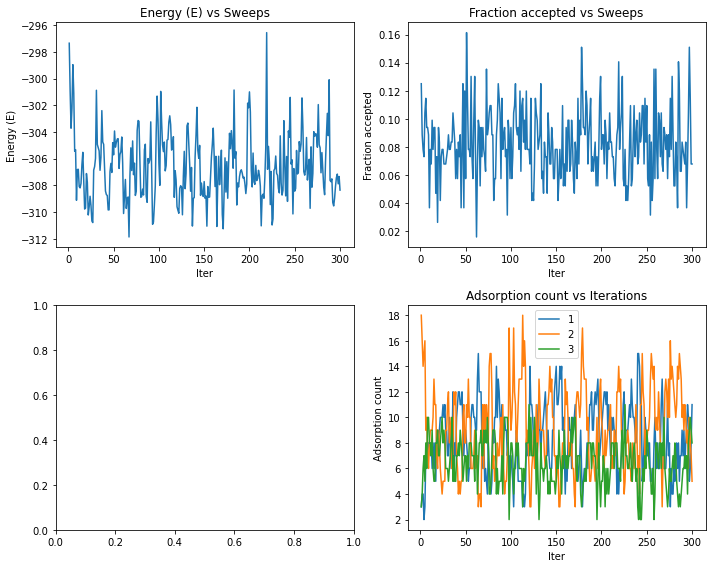

In [10]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

Try again with 0.99

In [3]:
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[4,4])
element = 'Au'
num_ads_atoms = 16 + 8 # for canonical runs
alpha = 0.99

start = perf_counter()
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

INFO:Running with num_runs = 300, temp = 1, pot = 0, alpha = 0.99
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


there are 64 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f081a6d7d90>


INFO:In pristine slab, there are a total of 192 sites
INFO:running for 192 iterations per run over a total of 300 runs
INFO:In sweep 1 out of 300
INFO:In sweep 2 out of 300
INFO:In sweep 3 out of 300
INFO:In sweep 4 out of 300
INFO:In sweep 5 out of 300
INFO:In sweep 6 out of 300
INFO:In sweep 7 out of 300
INFO:In sweep 8 out of 300
INFO:In sweep 9 out of 300
INFO:In sweep 10 out of 300
INFO:In sweep 11 out of 300
INFO:In sweep 12 out of 300
INFO:In sweep 13 out of 300
INFO:In sweep 14 out of 300
INFO:In sweep 15 out of 300
INFO:In sweep 16 out of 300
INFO:In sweep 17 out of 300
INFO:In sweep 18 out of 300
INFO:In sweep 19 out of 300
INFO:In sweep 20 out of 300
INFO:In sweep 21 out of 300
INFO:In sweep 22 out of 300
INFO:In sweep 23 out of 300
INFO:In sweep 24 out of 300
INFO:In sweep 25 out of 300
INFO:In sweep 26 out of 300
INFO:In sweep 27 out of 300
INFO:In sweep 28 out of 300
INFO:In sweep 29 out of 300
INFO:In sweep 30 out of 300
INFO:In sweep 31 out of 300
INFO:In sweep 32 out o

Time taken = 739.0090016869945 seconds


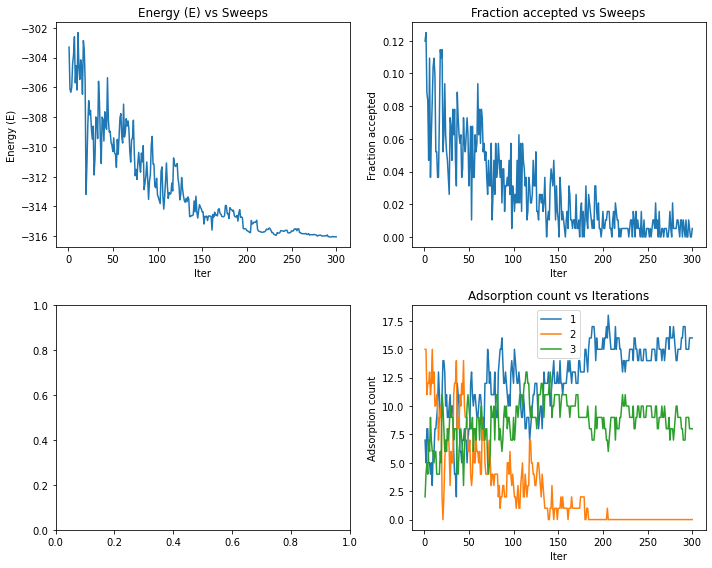

In [4]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

Large unit cell

In [5]:
slab, surface_atoms = surfaces.surface_from_bulk(atoms, [1,1,0], size=[8,8])
element = 'Au'
num_ads_atoms = 16 + 8 # for canonical runs
alpha = 0.99

start = perf_counter()
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=alpha, slab=slab, calc=lammps_calc, element=element, canonical=True, num_ads_atoms=num_ads_atoms)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

/home/dux/.local/lib/python3.9/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(
INFO:Running with num_runs = 300, temp = 1, pot = 0, alpha = 0.99


there are 256 atoms 
using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f081a6d7d90>


/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/.local/lib/python3.9/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)
INFO:In pristine slab, there are a total of 768 sites
/home/dux/miniconda3/envs/mlenv/lib/python3.9/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS 

Time taken = 6087.124666702002 seconds
